# Norne: Real field black-oil model
The Norne model is a real field model. The model has been adapted so that the
input file only contains features present in JutulDarcy, with the most notable
omissions being removal of hysteresis and threshold pressures between
equilibriation reqgions. For more details, see the [OPM data
webpage](https://opm-project.org/?page_id=559)

In [1]:
using Jutul, JutulDarcy, GLMakie, DelimitedFiles, HYPRE
norne_dir = JutulDarcy.GeoEnergyIO.test_input_file_path("NORNE_NOHYST")
case = setup_case_from_data_file(joinpath(norne_dir, "NORNE_NOHYST.DATA"))
ws, states = simulate_reservoir(case, output_substates = true)

     Failure artifact: NORNE_NOHYST
F-4H completion: Removed COMPDAT as (36, 68, 17) is not active in processed mesh.
Rel. Perm. Scaling: Three-point scaling active.
Transmissibility: Replaced 4615 negative half-transmissibilities (out of 265386, 1.74%) with their absolute value.
Transmissibility: Replaced 2 non-finite half-transmissibilities (out of 265386, 0.0%) with zero.
Transmissibility: Replaced 108 negative half-transmissibilities (out of 265386, 0.04%) with their absolute value.
Transmissibility: Replaced 2 non-finite half-transmissibilities (out of 265386, 0.0%) with zero.
Shutting D-1H: Well has no open perforations at step 137, shutting.
┌ Warning: Negative saturation in 215 cells for phase 2. Normalizing.
└ @ JutulDarcy ~/work/JutulDarcy.jl/JutulDarcy.jl/src/init/init.jl:746
Simulating 9 years, 3.545 weeks as 247 report steps   1%  ETA: 0:18:42
  Progress:  Solving step 2/247 (0.75% of time interval complete)


Simulating 9 years, 3.545 weeks as 247 report steps   1%  ETA: 

ReservoirSimResult with 474 entries:

  wells (36 present):
    :B-4H
    :F-4H
    :D-4H
    :F-2H
    :D-2H
    :B-1H
    :C-4H
    :C-1H
    :B-2H
    :E-1H
    :B-4BH
    :D-3AH
    :D-3BH
    :C-3H
    :E-3H
    :K-3H
    :E-4AH
    :D-1H
    :B-1AH
    :E-3CH
    :E-4H
    :E-2H
    :E-2AH
    :C-4AH
    :B-1BH
    :C-2H
    :B-4DH
    :D-3H
    :E-3AH
    :D-4AH
    :B-3H
    :F-3H
    :E-3BH
    :D-1CH
    :F-1H
    :B-4AH
    Results per well:
       :wrat => Vector{Float64} of size (474,)
       :Aqueous_mass_rate => Vector{Float64} of size (474,)
       :orat => Vector{Float64} of size (474,)
       :bhp => Vector{Float64} of size (474,)
       :lrat => Vector{Float64} of size (474,)
       :mass_rate => Vector{Float64} of size (474,)
       :rate => Vector{Float64} of size (474,)
       :Vapor_mass_rate => Vector{Float64} of size (474,)
       :control => Vector{Symbol} of size (474,)
       :Liquid_mass_rate => Vector{Float64} of size (474,)
       :grat => Vector{Float64}

## Plot the reservoir solution

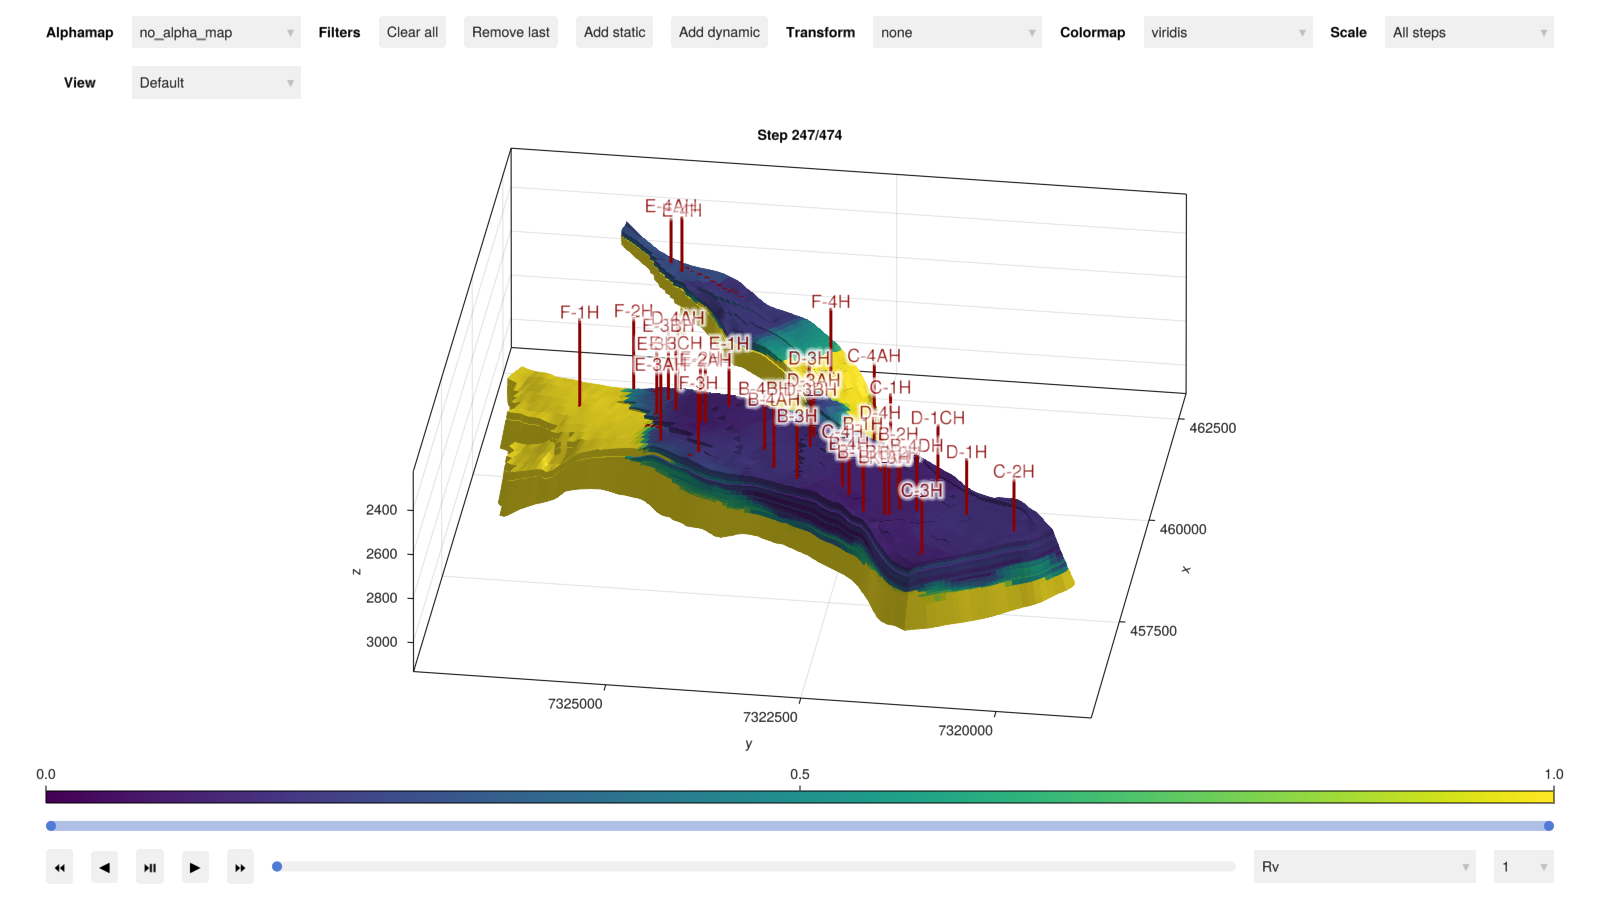

In [2]:
fig = plot_reservoir(case.model, states, step = 247, key = :Saturations)
ax = fig.current_axis[]
ax.azimuth[] = -3.0
ax.elevation[] = 0.5
fig

## Plot the reservoir static properties

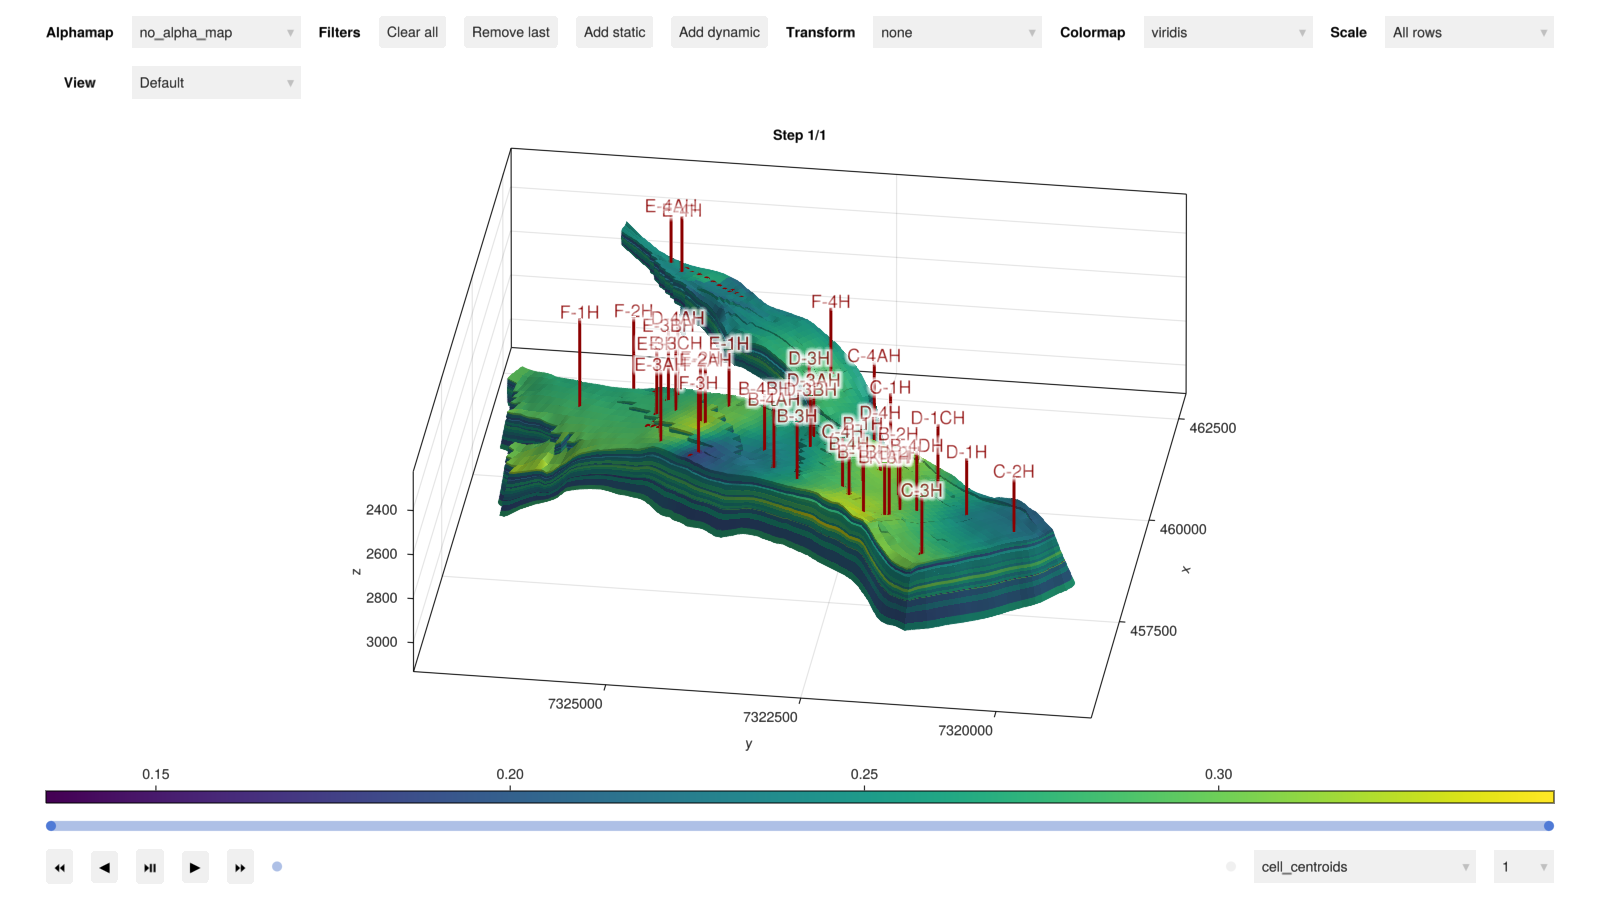

In [3]:
fig = plot_reservoir(case.model, key = :porosity)
ax = fig.current_axis[]
ax.azimuth[] = -3.0
ax.elevation[] = 0.5
fig

## Load reference and set up plotting

In [4]:
csv_path = joinpath(norne_dir, "REFERENCE.CSV")
data, header = readdlm(csv_path, ',', header = true)
time_ref = data[:, 1]
time_jutul = deepcopy(ws.time)
wells = deepcopy(ws.wells)
wnames = collect(keys(wells))
nw = length(wnames)
day = si_unit(:day)
cmap = :tableau_hue_circle

inj = Symbol[]
prod = Symbol[]
for (wellname, well) in pairs(wells)
    qts = well[:wrat] + well[:orat] + well[:grat]
    if sum(qts) > 0
        push!(inj, wellname)
    else
        push!(prod, wellname)
    end
end

function plot_well_comparison(response, well_names, reponse_name = "$response")
    fig = Figure(size = (1000, 400))
    if response == :bhp
        ys = 1/si_unit(:bar)
        yl = "Bottom hole pressure / Bar"
    elseif response == :wrat
        ys = si_unit(:day)
        yl = "Surface water rate / m³/day"
    elseif response == :grat
        ys = si_unit(:day)/1e6
        yl = "Surface gas rate / 10⁶ m³/day"
    elseif response == :orat
        ys = si_unit(:day)/(1000*si_unit(:stb))
        yl = "Surface oil rate / 10³ stb/day"
    else
        error("$response not ready.")
    end
    welltypes = []
    ax = Axis(fig[1:4, 1], xlabel = "Time / days", ylabel = yl)
    i = 1
    linehandles = []
    linelabels = []
    for well_name in well_names
        well = wells[well_name]
        label_in_csv = "$well_name:$response"
        ref_pos = findfirst(x -> x == label_in_csv, vec(header))
        qoi = copy(well[response]).*ys
        qoi_ref = data[:, ref_pos].*ys
        tot_rate = copy(well[:rate])
        @. qoi[tot_rate == 0] = NaN
        grat_ref = data[:, findfirst(x -> x == "$well_name:grat", vec(header))]
        orat_ref = data[:, findfirst(x -> x == "$well_name:orat", vec(header))]
        wrat_ref = data[:, findfirst(x -> x == "$well_name:wrat", vec(header))]
        tot_rate_ref = grat_ref + orat_ref + wrat_ref
        @. qoi_ref[tot_rate_ref == 0] = NaN
        crange = (1, max(length(well_names), 2))
        lh = lines!(ax, time_jutul./day, abs.(qoi),
            color = i,
            colorrange = crange,
            label = "$well_name", colormap = cmap
        )
        push!(linehandles, lh)
        push!(linelabels, "$well_name")
        lines!(ax, time_ref./day, abs.(qoi_ref),
            color = i,
            colorrange = crange,
            linestyle = :dash,
            colormap = cmap
        )
        i += 1
    end
    l1 = LineElement(color = :black, linestyle = nothing)
    l2 = LineElement(color = :black, linestyle = :dash)

    Legend(fig[1:3, 2], linehandles, linelabels, nbanks = 3)
    Legend(fig[4, 2], [l1, l2], ["JutulDarcy.jl", "OPM Flow"])
    fig
end

plot_well_comparison (generic function with 2 methods)

## Injector bhp

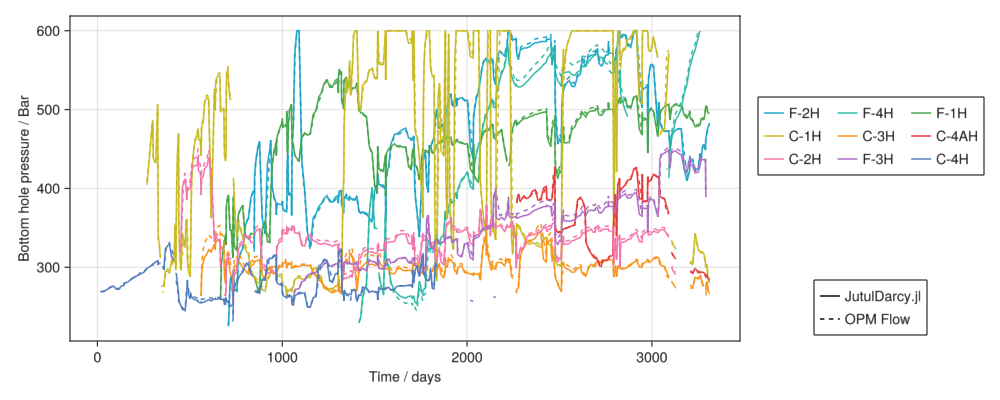

In [5]:
plot_well_comparison(:bhp, inj, "Bottom hole pressure")

## Gas injection rates

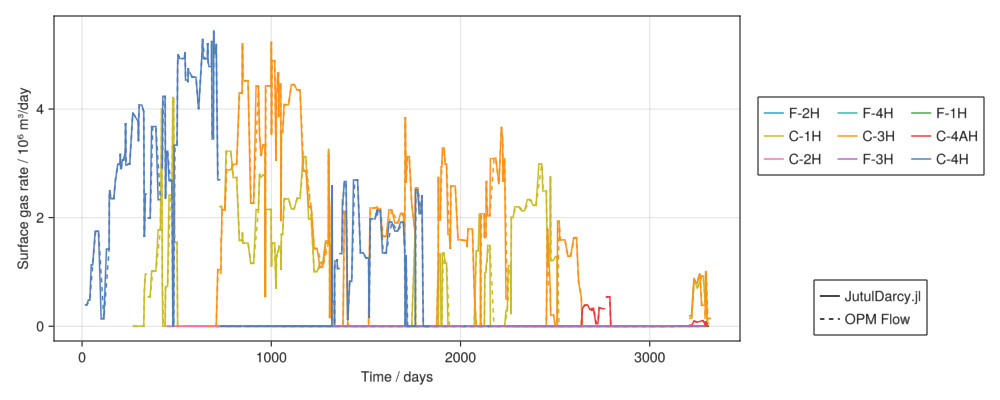

In [6]:
plot_well_comparison(:grat, inj, "Gas surface injection rate")

## Water injection rates

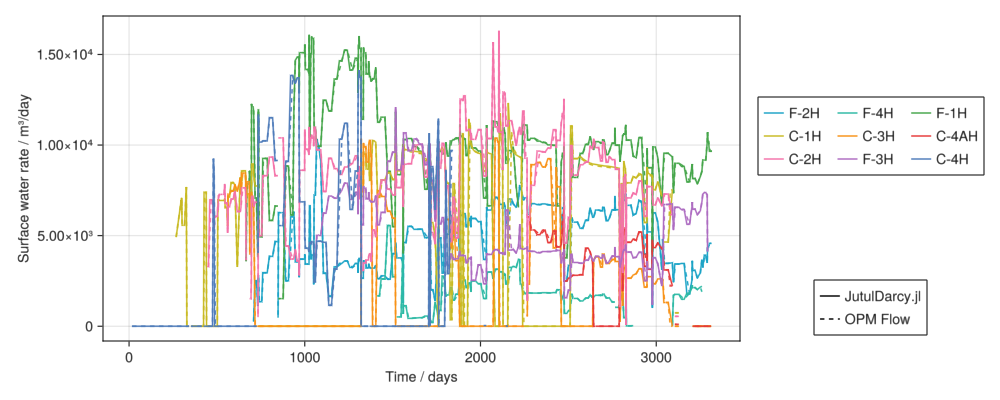

In [7]:
plot_well_comparison(:wrat, inj, "Water surface injection rate")

## Producer bhp

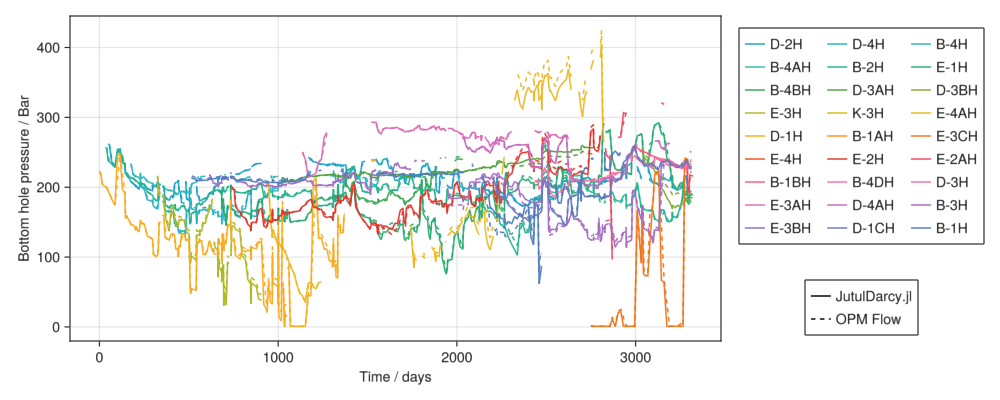

In [8]:
plot_well_comparison(:bhp, prod, "Bottom hole pressure")

## Oil production rates

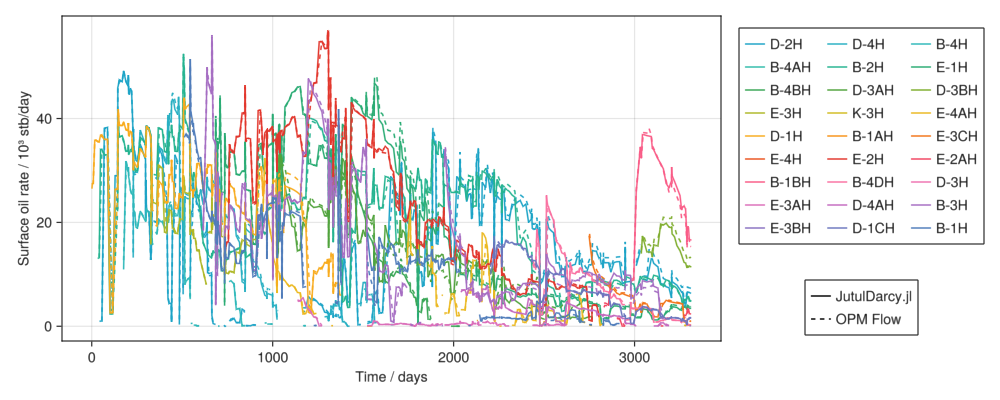

In [9]:
plot_well_comparison(:orat, prod, "Oil surface production rate")

## Gas production rates

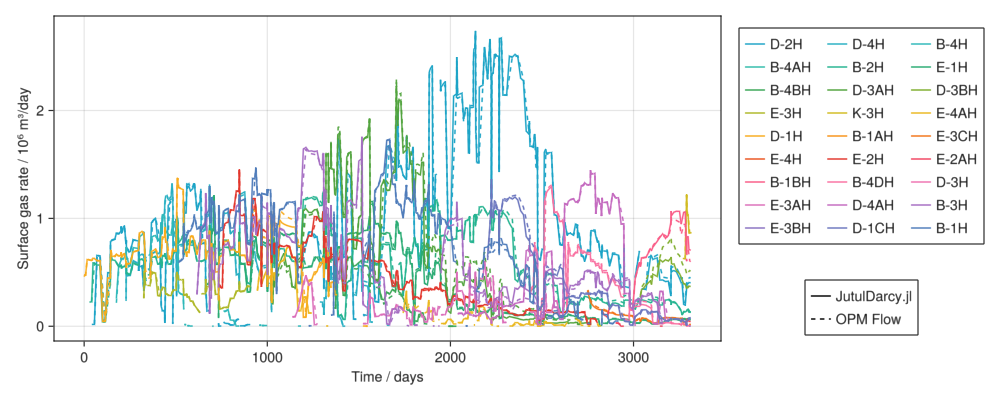

In [10]:
plot_well_comparison(:grat, prod, "Gas surface production rate")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*